### Plot calalogues informations for INGV, OV and merged catalogue

In [1]:
from pyrocko import util, model, io, trace, moment_tensor, gmtpy
from pyrocko import pz
from pyrocko import orthodrome as od
from pyrocko.io import quakeml
from pyrocko.io import stationxml as fdsn
from pyrocko.client import catalog
from pyrocko.automap import Map
import pyrocko.moment_tensor as pmt
from seiscloud import plot as scp
from seiscloud import cluster as scc
import numpy as num
import os, sys, re, math, shutil
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib import dates
import datetime
import urllib.request
from pyrocko.plot.gmtpy import GMT
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime


In [2]:
workdir='../'
catdir =  os.path.join(workdir,'CAT')
plot_dir= os.path.join(workdir,'PLOTS')

catname_INGV = os.path.join(catdir, 'INGV/catalogue_flegrei_INGV.pf')                 
events_INGV = model.load_events(catname_INGV)

catname_GOSSIP = os.path.join(catdir, 'GOSSIP/catalogue_flegrei_GOSSIP.pf')                 
events_GOSSIP = model.load_events(catname_GOSSIP)

catname_final = os.path.join(catdir, 'catalogue_flegrei_mag_2_5.pf')                 
events_final = model.load_events(catname_final)

In [3]:
#################################################
#######################CHANGE####################
INGV= False                      
GOSSIP= True                    
#######################CHANGE####################
#################################################

if INGV and GOSSIP:
    print('ERROR: select only one catalogue')
elif INGV:
    events= events_INGV
    name='INGV'
elif GOSSIP:
    events= events_GOSSIP
    name='GOSSIP'
else:
    print('ERROR: select a catalogue.')

print('selected catalogue:',name)
print(len(events))

selected catalogue: GOSSIP
12746


In [7]:
# ORIGIN TIMES OF EVENTS IN CATALOGUE
times= [ev.time for ev in events]
eq_dates = [datetime.datetime.fromtimestamp(t) for t in times]
#dates_day= [date.date().isoformat() for date in eq_dates]     #redundant

times_final= [ev.time for ev in events_final]
eq_dates_final=[datetime.datetime.fromtimestamp(t) for t in times_final]
# MAGNITUDE PER DAY

mag_ev = [ev.magnitude for ev in events]

mag_ev_final=[]
for ev in events_final:
    mag_ev_final.append( float(ev.tags[1].split(':')[1]) )
# RATE: NUMBER OF EVENTS PER MONTH
#time axis spaced by month
time_ax_month = num.arange('2014-01-01', '2025-01-01', dtype='datetime64[M]')           ###CHANGE###

#event rate
rate_events_month=[]
n=0

for t in time_ax_month:
    month = str(t)
    for ev in eq_dates:
        if month == str(ev)[:7]:
            n+=1
    rate_events_month.append(n)
    n=0

# NUMBER OF EVENTS PER DAY
# time axis spaced by day
time_ax = num.arange('2014-01-01', '2025-01-01', dtype='datetime64[D]')                 ###CHANGE###

#cumulative events
rate_events_day=[]
n=0

for t in time_ax:
    day = str(t)
    for ev in eq_dates:
        if day == str(ev)[:10]:
            n+=1
    rate_events_day.append(n)
    n=0

#CUMULATIVE EVENTS PER DAY
# time axis spaced by day
time_ax = num.arange('2014-01-01', '2025-01-01', dtype='datetime64[D]')             ###CHANGE###

#cumulative events
n_events=[]
n=0
total_ev=0

for t in time_ax:
    day = str(t)
    for ev in eq_dates:
        if day == str(ev)[:10]:
            n+=1
    n_events.append(n+total_ev)
    total_ev+=n
    n=0

# SUBPLOTS MAGNITUDE, RATE, EVENTS

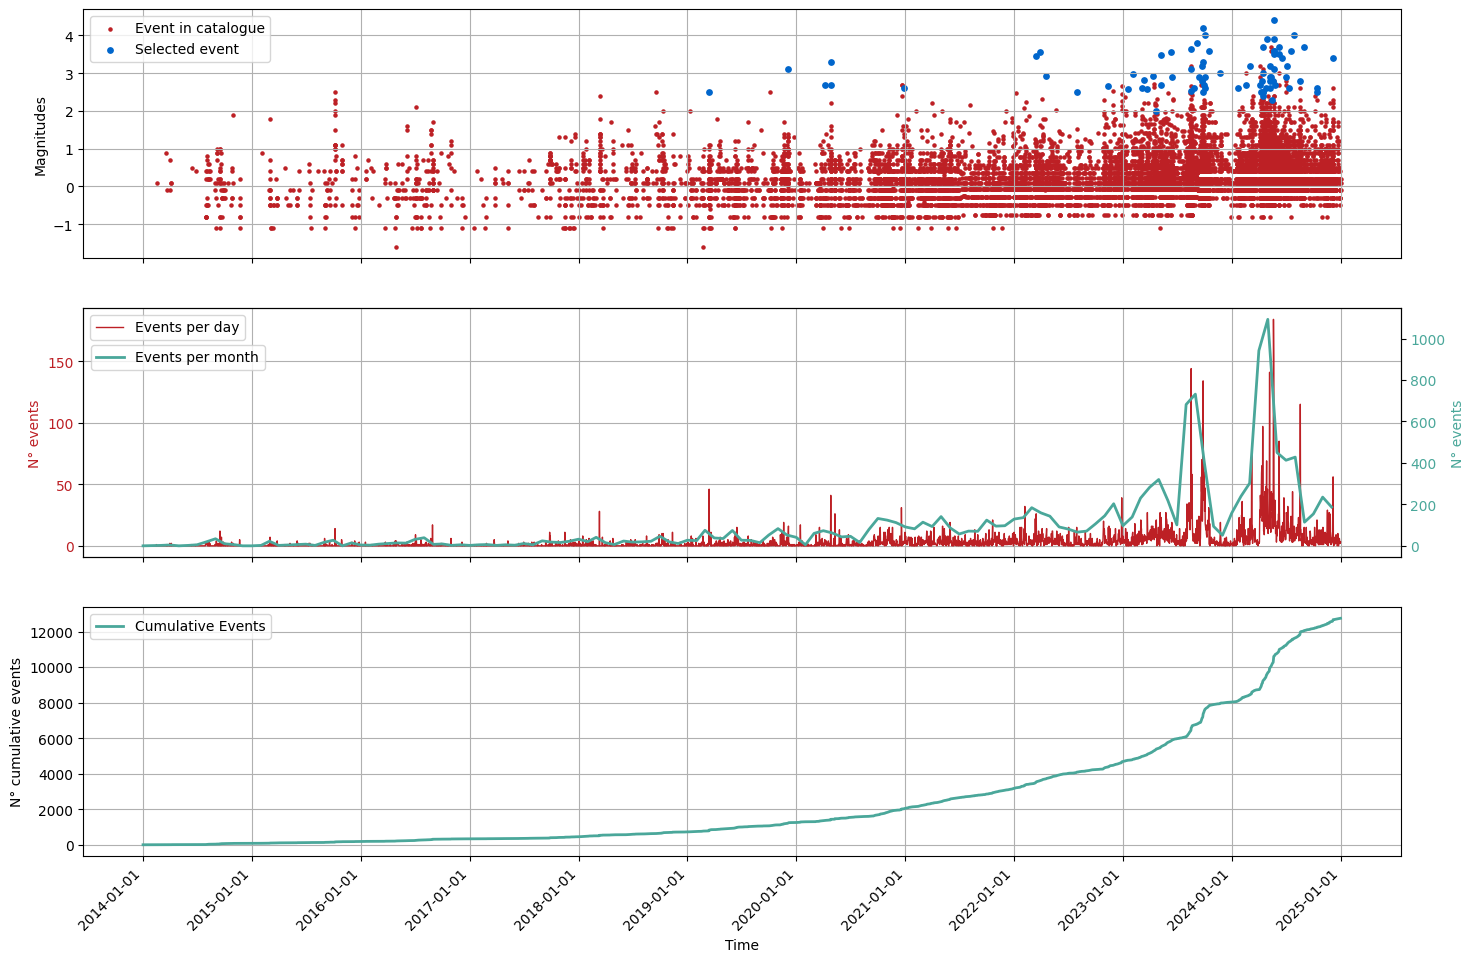

In [8]:
#SAVE FIGURE SWITCH
save_fig1=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(3, 1, figsize=(17,11), sharex=True)

color3="#0066cc" #blue
color2="#BD2025" #red           #"#FFCC4E" #yellow
color1='#4AA79A' #green

# Plot per il primo subplot
axs[0].scatter(num.array(eq_dates),
                num.array(mag_ev),
                label='Event in catalogue', s=5, color=color2)
axs[0].set_ylabel('Magnitudes')
axs[0].grid(True)
axs[0].scatter(num.array(eq_dates_final),
                num.array(mag_ev_final),
                label='Selected event', s=15, color=color3)
axs[0].legend()

# Plot per il secondo subplot
axs[1].plot(time_ax,rate_events_day, color=color2, label='Events per day', linewidth=1)
axs[1].set_ylabel('N° events',color=color2)                                      
axs[1].tick_params(axis='y', labelcolor=color2)   
axs[1].grid(True)                                                                            
axs[1].legend()                                

# second line in subplot 2
ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(time_ax_month,rate_events_month, color=color1, label='Events per month', linewidth=2)
ax2.set_ylabel('N° events',color=color1)                                                
ax2.tick_params(axis='y', labelcolor=color1)                                             
ax2.legend(loc='upper left', bbox_to_anchor=(0.0005, 0.88)) #try and error parameters


# Plot per il terzo subplot
axs[2].plot(time_ax, n_events , color=color1, label='Cumulative Events', linewidth=2)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('N° cumulative events')
axs[2].grid(True)
axs[2].legend()

# Formattazione dell'asse delle ascisse 
#axs[2].xaxis.set_major_locator(dates.AutoDateLocator(minticks=num_intervals))
axs[2].xaxis.set_major_locator(dates.YearLocator(1))  # Un'etichetta ogni anno

axs[2].xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

# Imposta l'etichetta dell'asse x (condivisa tra i subplot) con orientazione inclinata
for label in axs[2].xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

if save_fig1:

    plot_name= os.path.join(plot_dir, name)

    figname = os.path.join(plot_name, 'catologue_flegrei_2_'+name+'.pdf')
    if os.path.isfile(figname):
        os.remove(figname)

    plt.savefig(figname)

    figname_svg = os.path.join(plot_name, 'catologue_flegrei_2_'+name+'.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)


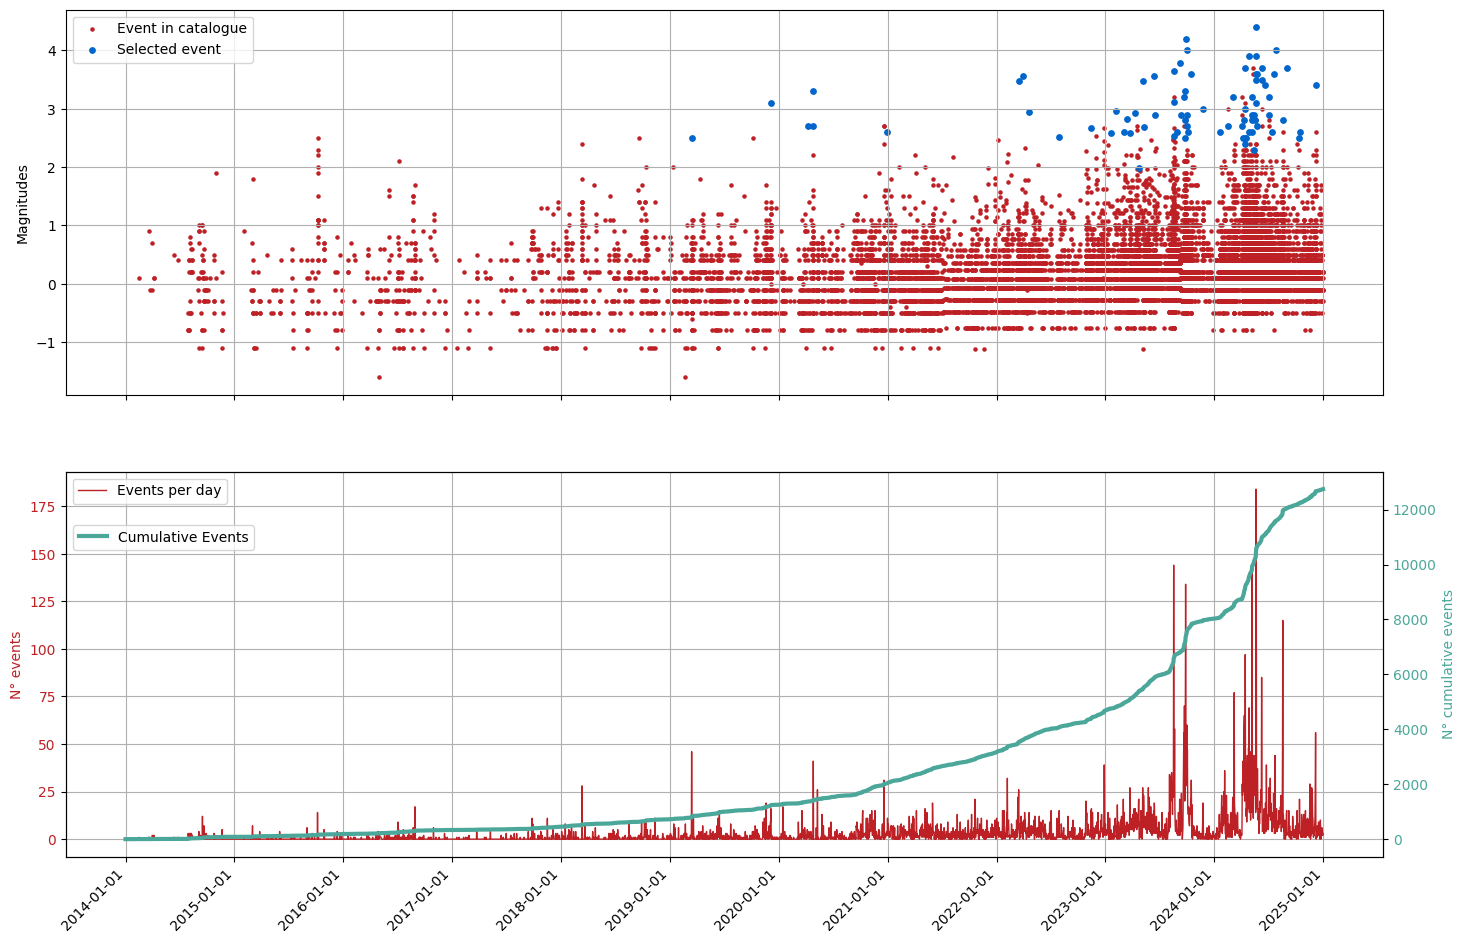

In [9]:
#SAVE FIGURE SWITCH
save_fig1b=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(2, 1, figsize=(17,11), sharex=True)

color3="#0066cc" #blue
color2="#BD2025" #red           #"#FFCC4E" #yellow
color1='#4AA79A' #green

# Plot per il primo subplot
axs[0].scatter(num.array(eq_dates),
                num.array(mag_ev),
                label='Event in catalogue', s=5, color=color2)
axs[0].set_ylabel('Magnitudes')
axs[0].grid(True)
axs[0].scatter(num.array(eq_dates_final),
                num.array(mag_ev_final),
                label='Selected event', s=15, color=color3)
axs[0].legend()

# Plot per il secondo subplot
axs[1].plot(time_ax,rate_events_day, color=color2, label='Events per day', linewidth=1)
axs[1].set_ylabel('N° events',color=color2)                                      
axs[1].tick_params(axis='y', labelcolor=color2)   
axs[1].grid(True)                                                                            
axs[1].legend()                                

# second line in subplot 2
ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(time_ax, n_events , color=color1, label='Cumulative Events', linewidth=3)
ax2.set_ylabel('N° cumulative events',color=color1)                                                
ax2.tick_params(axis='y', labelcolor=color1)                                             
ax2.legend(loc='upper left', bbox_to_anchor=(0.0005, 0.88)) #try and error parameters


# Formattazione dell'asse delle ascisse 
#axs[2].xaxis.set_major_locator(dates.AutoDateLocator(minticks=num_intervals))
axs[1].xaxis.set_major_locator(dates.YearLocator(1))  # Un'etichetta ogni anno

axs[1].xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

# Imposta l'etichetta dell'asse x (condivisa tra i subplot) con orientazione inclinata
for label in axs[1].xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

if save_fig1b:

    plot_name= os.path.join(plot_dir, name)

    figname = os.path.join(plot_name, 'catologue_flegrei_'+name+'.pdf')
    if os.path.isfile(figname):
        os.remove(figname)

    plt.savefig(figname)

    figname_svg = os.path.join(plot_name, 'catologue_flegrei_'+name+'.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)


# CROSS SECTIONS and MAP PLOTS

In [10]:
lat_ingv= [ev.lat for ev in events_INGV]
lat_gossip= [ev.lat for ev in events_GOSSIP]

minlat= num.min(num.array(lat_gossip))
maxlat= num.max(num.array(lat_gossip))

lon_ingv= [ev.lon for ev in events_INGV]
lon_gossip= [ev.lon for ev in events_GOSSIP]

minlon= num.min(num.array(lon_gossip))
maxlon= num.max(num.array(lon_gossip))

d_ingv= [ev.depth for ev in events_INGV]
d_gossip= [ev.depth for ev in events_GOSSIP]

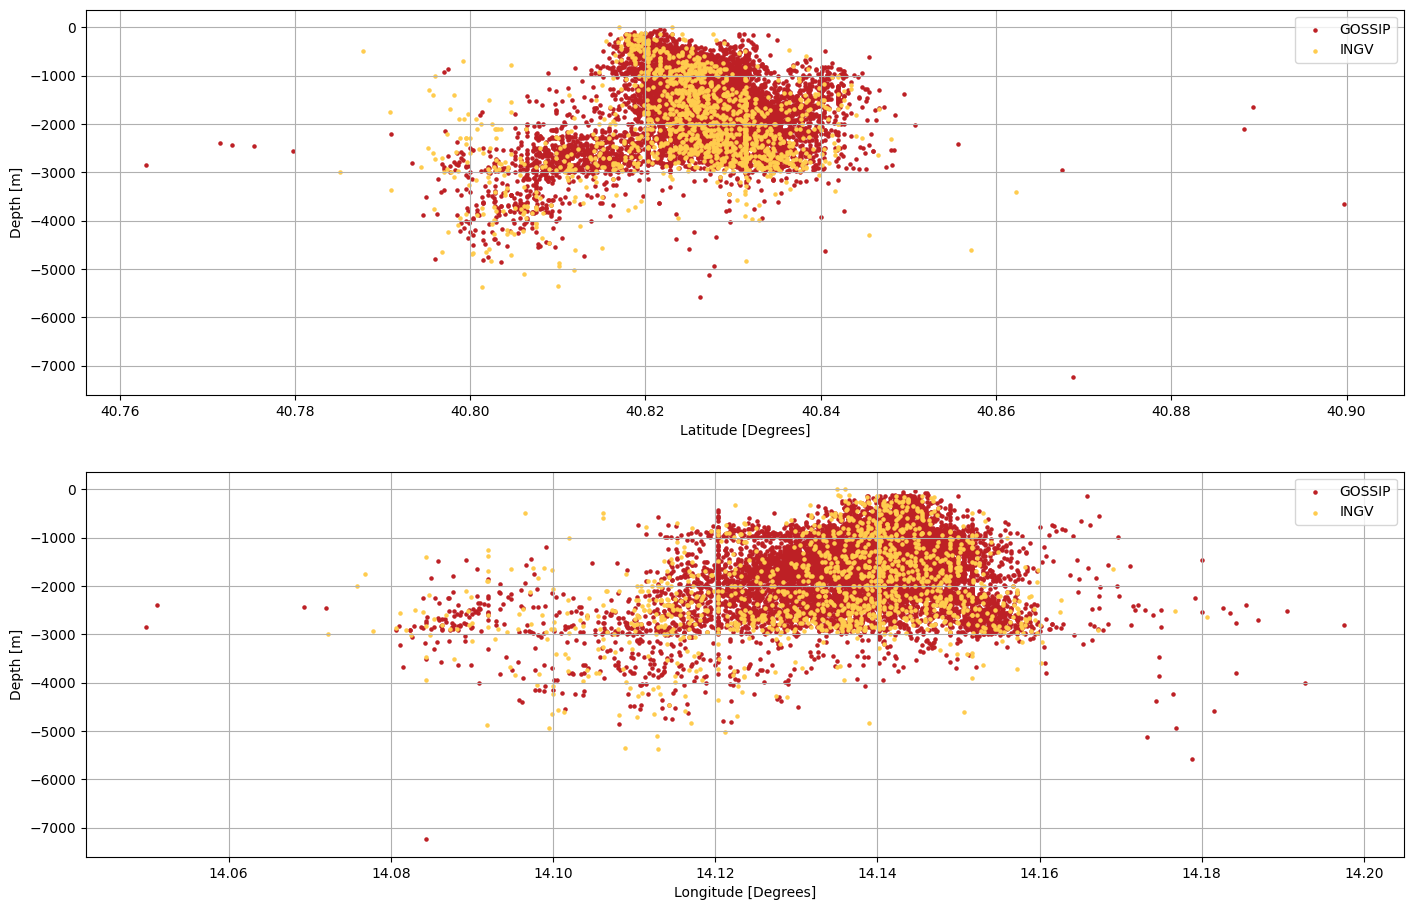

In [11]:
#SAVE FIGURE SWITCH
save_fig2=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(2, 1, figsize=(17, 11), sharex=False)

color1="#BD2025" #red
color2="#FFCC4E" #yellow

# Plot per il primo subplot
axs[0].scatter(num.array(lat_gossip),
                -num.array(d_gossip),
                label='GOSSIP', s=5, color=color1)
axs[0].scatter(num.array(lat_ingv),
                -num.array(d_ingv),
                label='INGV', s=5, color=color2)
axs[0].set_ylabel('Depth [m]')
axs[0].grid(True)
axs[0].set_xlabel('Latitude [Degrees]')
axs[0].legend()

# Plot per il secondo subplot
axs[1].scatter(num.array(lon_gossip),
                -num.array(d_gossip),
                label='GOSSIP', s=5,color=color1)
axs[1].scatter(num.array(lon_ingv),
                -num.array(d_ingv),
                label='INGV', s=5, color=color2)
axs[1].set_ylabel('Depth [m]')
axs[1].grid(True)
axs[1].set_xlabel('Longitude [Degrees]')
axs[1].legend()

if save_fig2:
    figdir=os.path.join(plot_dir, 'CAT_ALL')
    figname = os.path.join(figdir, 'catologue_flegrei_cross_section.pdf')
    if os.path.isfile(figname):
        os.remove(figname)
    plt.savefig(figname)
    
    figdir=os.path.join(plot_dir, 'CAT_ALL')
    figname_svg = os.path.join(figdir, 'catologue_flegrei_cross_section.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)


# PLOT MAP (GMTPY not working)

In [8]:
#from pyrocko.plot.gmtpy import GMT

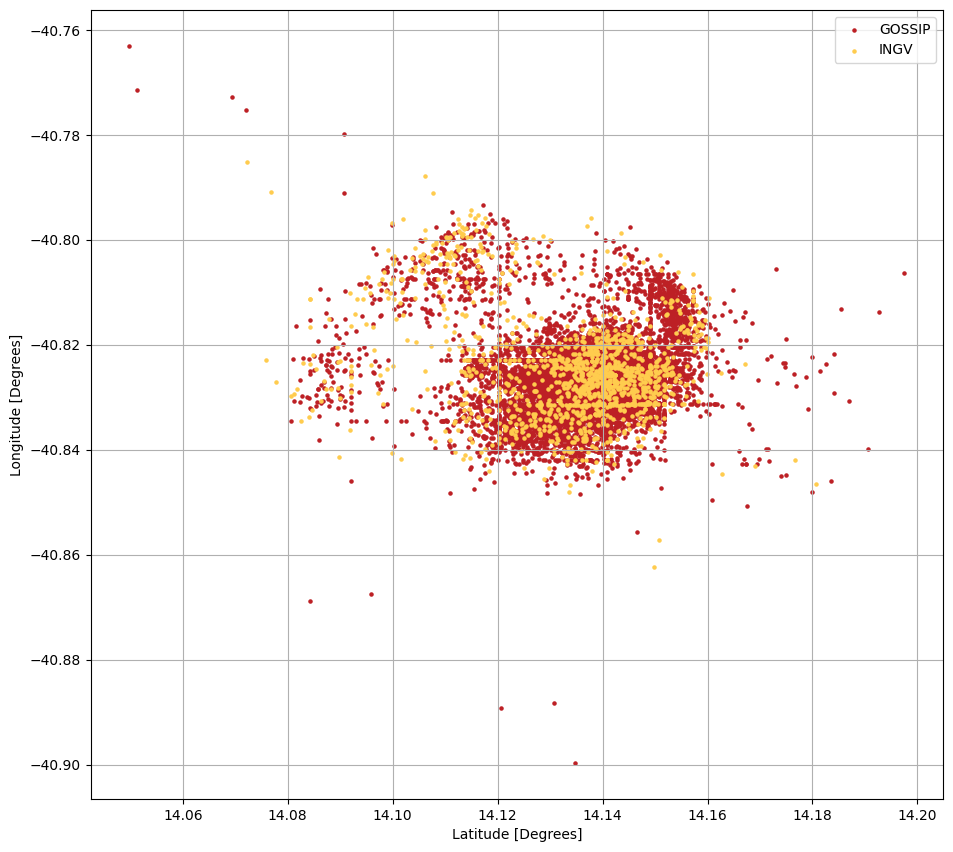

In [12]:
#SAVE FIGURE SWITCH
save_fig3=True

color1="#BD2025" #red
color2="#FFCC4E" #yellow

# Creazione della figura e dei subplot
fig, axs = plt.subplots(1, 1, figsize=(11, 11), sharex=False)

# Plot per il primo subplot
axs.scatter(num.array(lon_gossip),
                -num.array(lat_gossip),
                label='GOSSIP', s=5, color=color1)
axs.scatter(num.array(lon_ingv),
                -num.array(lat_ingv),
                label='INGV', s=5, color=color2)
axs.set_aspect('equal', 'box')
axs.set_ylabel('Longitude [Degrees]')
axs.grid(True)
axs.set_xlabel('Latitude [Degrees]')
axs.legend()

if save_fig3:
    figdir=os.path.join(plot_dir, 'CAT_ALL')
    figname = os.path.join(figdir, 'catologue_flegrei_map.pdf')
    if os.path.isfile(figname):
        os.remove(figname)
    plt.savefig(figname)

    figdir=os.path.join(plot_dir, 'CAT_ALL')
    figname_svg = os.path.join(figdir, 'catologue_flegrei_map.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)


# HISTOGRAM

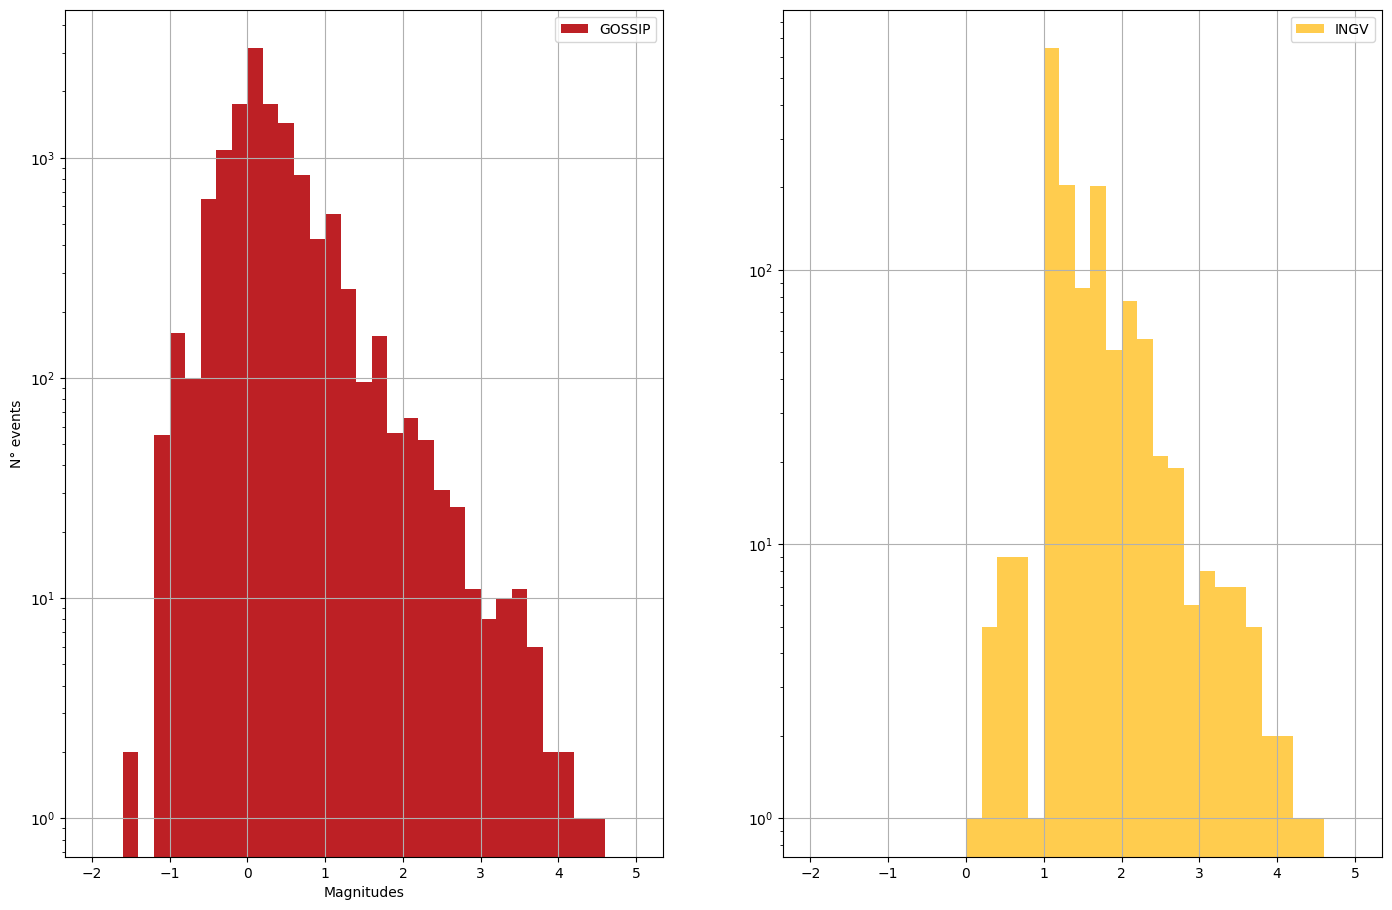

In [17]:
mag_INGV = [ev.magnitude for ev in events_INGV]
mag_GOSSIP = [ev.magnitude for ev in events_GOSSIP]

#max_mag=max(mag_GOSSIP)
#min_mag=min(mag_GOSSIP)

#SAVE FIGURE SWITCH
save_fig4=True

color1="#BD2025" #red
color2="#FFCC4E" #yellow

# Creazione della figura e dei subplot
fig, axs = plt.subplots(1, 2, figsize=(17, 11), sharex=False)

# Plot per il primo subplot
axs[0].hist(mag_GOSSIP, bins=35,range=[-2,5],
                label='GOSSIP', color=color1,log=True)
axs[0].set_ylabel('N° events')
axs[0].grid(True)
axs[0].set_xlabel('Magnitudes')
axs[0].legend()

# Plot per il secondo subplot
axs[1].hist(mag_INGV,bins=35,range=[-2,5],
                label='INGV', color=color2,log=True)
axs[0].set_ylabel('N° events')
axs[1].grid(True)
axs[0].set_xlabel('Magnitudes')
axs[1].legend()
if save_fig4:

    figdir=os.path.join(plot_dir, 'CAT_ALL')
    figname = os.path.join(figdir, 'catologue_flegrei_hist.pdf')
    if os.path.isfile(figname):
        os.remove(figname)
    plt.savefig(figname)
    
    figdir=os.path.join(plot_dir, 'CAT_ALL')
    figname_svg = os.path.join(figdir, 'catologue_flegrei_hist.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)

# FINAL CATALOGUE

In [18]:
catname_final = os.path.join(catdir, 'catalogue_flegrei_mag_2_5.pf')                 
events_final = model.load_events(catname_final)
len(events_final)

79

In [19]:
lat= [ev.lat for ev in events_final]

lon= [ev.lon for ev in events_final]

d= [ev.depth for ev in events_final]

time=[ev.time for ev in events_final]


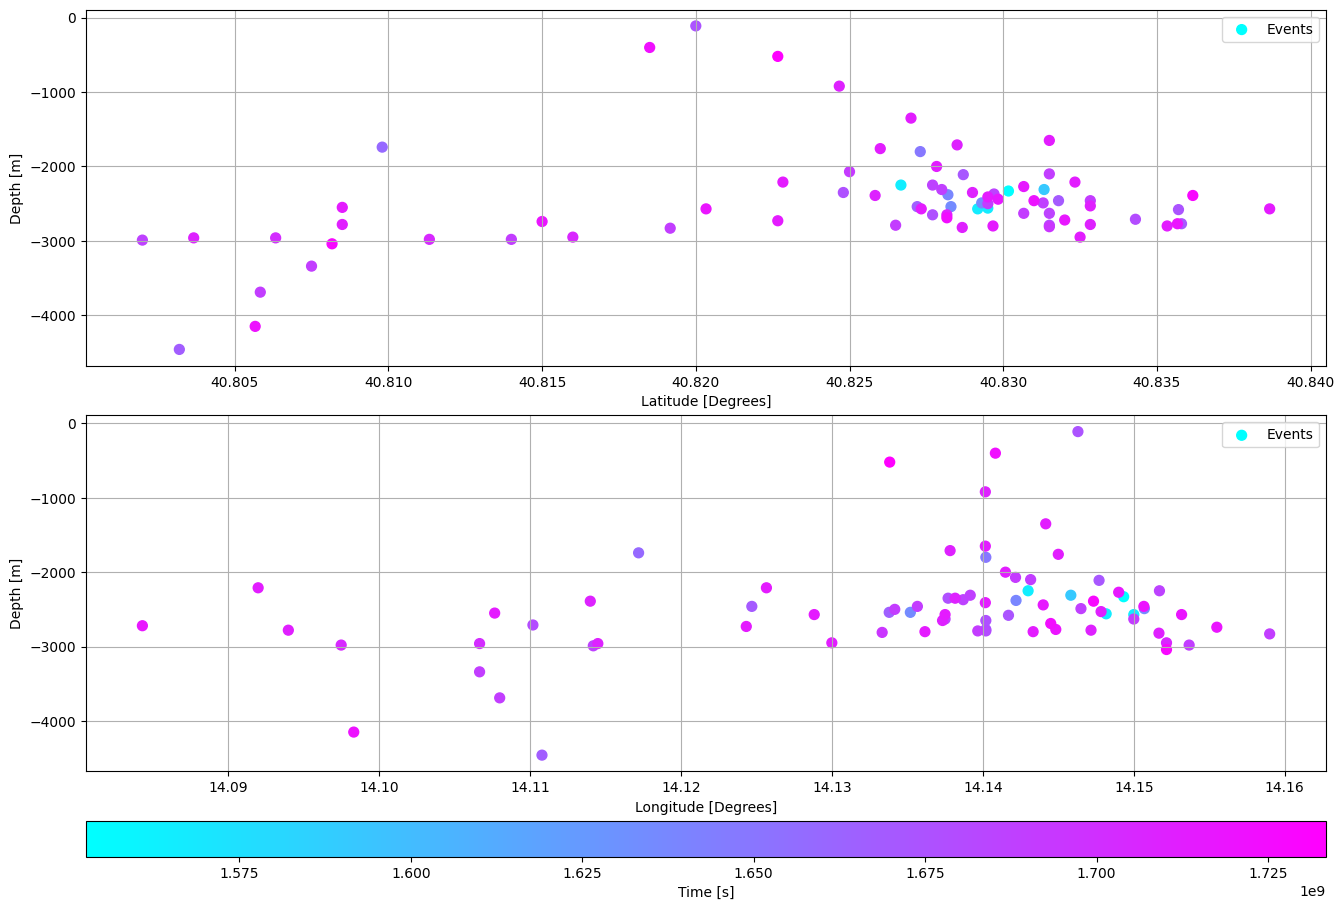

In [20]:
import matplotlib as mpl

#SAVE FIGURE SWITCH
save_fig5=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(3, 1, figsize=(16, 11), height_ratios=[3,3,0.3], sharex=False)
colmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=int(min(time)), vmax=int(max(time)))

# Plot per il primo subplot
axs[0].scatter(num.array(lat[1:]),
                -num.array(d[1:]),
                label='Events', s=50, cmap=colmap, c=num.array(time[1:]))
axs[0].set_ylabel('Depth [m]')
axs[0].grid(True)
axs[0].set_xlabel('Latitude [Degrees]')
axs[0].legend()

# Plot per il secondo subplot
axs[1].scatter(num.array(lon[1:]),
                -num.array(d[1:]),
                label='Events', s=50, cmap=colmap, c=num.array(time[1:]) ) 
axs[1].set_ylabel('Depth [m]')
axs[1].grid(True)
axs[1].set_xlabel('Longitude [Degrees]')
axs[1].legend()

fig.colorbar( mpl.cm.ScalarMappable(norm=norm, cmap=colmap) , 
             cax=axs[2], orientation='horizontal', label='Time [s]')

if save_fig5:
    figdir=os.path.join(plot_dir, 'CAT_MAG2_5')
    figname = os.path.join(figdir, 'catologue_flegrei_cross_section.pdf')
    if os.path.isfile(figname):
        os.remove(figname)

    plt.savefig(figname)
    figdir=os.path.join(plot_dir, 'CAT_MAG2_5')
    figname_svg = os.path.join(figdir, 'catologue_flegrei_cross_section.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)

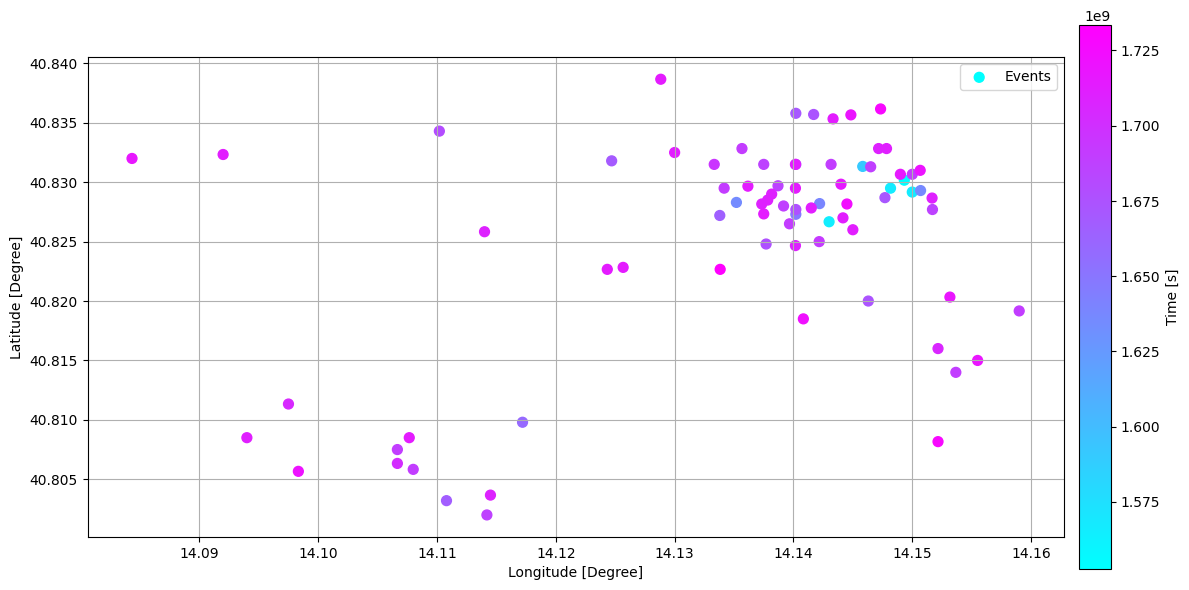

In [21]:
import matplotlib as mpl

#SAVE FIGURE SWITCH
save_fig6=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[3, 0.1], sharex=False,layout='tight')
colmap = mpl.cm.cool
colmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=int(min(time)), vmax=int(max(time)))

# Plot per il primo subplot
axs[0].scatter(num.array(lon[1:]),
                num.array(lat[1:]),
                label='Events', s=50, cmap=colmap, c=num.array(time[1:]))
axs[0].set_aspect('equal', 'box')
axs[0].set_ylabel('Latitude [Degree]')
axs[0].grid(True)
axs[0].set_xlabel('Longitude [Degree]')
axs[0].legend()

fig.colorbar( mpl.cm.ScalarMappable(norm=norm, cmap=colmap) , 
             cax=axs[1], orientation='vertical', label='Time [s]')

if save_fig6:
    figdir=os.path.join(plot_dir, 'CAT_MAG2_5')
    figname = os.path.join(figdir, 'catologue_flegrei_map.pdf')
    if os.path.isfile(figname):
        os.remove(figname)

    plt.savefig(figname)
    figdir=os.path.join(plot_dir, 'CAT_MAG2_5')
    figname_svg = os.path.join(figdir, 'catologue_flegrei_map.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)